In [13]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
train_data = FashionMNIST(root = './data', train = True, 
                          transform = ToTensor(), target_transform = None,
                          download = True)

test_data = FashionMNIST(root = './data', train = True,
                         transform = ToTensor(), target_transform = None,
                         download = True)

In [17]:
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = True)

In [18]:
class LeNet(nn.Module):
  def __init__(self, lr = 0.1, num_classes = 10):
    super().__init__()
    self.conv = nn.Sequential(
        nn.LazyConv2d(6, kernel_size = 5, stride = 1, padding = 2),
        nn.Sigmoid(),
        nn.LazyConv2d(16, kernel_size = 5, stride = 2),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size = 2, stride = 2),
        nn.Flatten(),
        nn.LazyLinear(120),
        nn.Sigmoid(),
        nn.LazyLinear(84),
        nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, x):
    x = self.conv(x)
    return x

  def layer_summary(self, X_shape):
    X = torch.randn(X_shape).to(device)
    for layer in self.conv:
      X = layer(X)
      print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [19]:
model = LeNet().to(device)
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
Sigmoid output shape:	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [20]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
acc = Accuracy(task = 'multiclass', num_classes = 10).to(device)

In [26]:
def train_step(model, train_loader, criterion, optimizer, acc, device):
  train_loss = 0
  train_acc = 0

  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    preds = model(X)
    loss = criterion(preds, y)
    train_loss += loss.item()
    train_acc += acc(preds, y).item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [27]:
def test_step(model, test_loader, criterion, acc, device):
  test_loss = 0
  test_acc = 0
  
  model.eval() 
  with torch.inference_mode():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      preds = model(X)
      test_loss += criterion(preds, y).item()
      test_acc += acc(preds, y).item()

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

  return test_loss, test_acc

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
  train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, acc, device)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_loss, test_acc = test_step(model, test_loader, criterion, acc, device)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

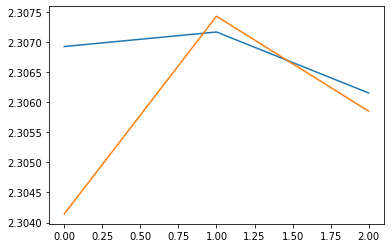

In [24]:
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), test_losses)

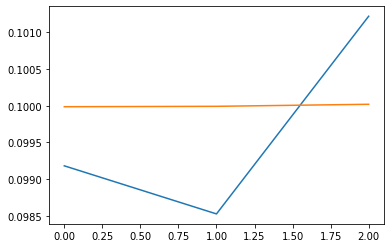

In [29]:
plt.plot(range(epochs), train_accs)
plt.plot(range(epochs), test_accs)